In [2]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import jax
import jax.numpy as jnp
from jax import vmap, grad, jit
from jax import random

from gpx.models import GPR
from gpx.kernels import SquaredExponential
from gpx.parameters import Parameter
from gpx.priors import NormalPrior
from gpx.utils import softplus, inverse_softplus

import matplotlib as mpl
import matplotlib.pyplot as plt

plt.style.use("dark_background")

%load_ext autoreload
%autoreload 2

In [2]:
jax.config.x64_enabled

True

Generate synthetic data

In [3]:
train_x = jnp.linspace(0, 1, 100)
key = random.PRNGKey(0)
train_y = jnp.sin(train_x * (2 * jnp.pi)) + random.normal(
    key, shape=train_x.shape
) * jnp.sqrt(0.04)
test_x = jnp.linspace(-0.5, 1.5, 51)
test_f = jnp.sin(test_x * (2 * jnp.pi))

train_x = train_x.reshape(-1, 1)
train_y = train_y.reshape(-1, 1)
test_x = test_x.reshape(-1, 1)
test_f = test_f.reshape(-1, 1)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


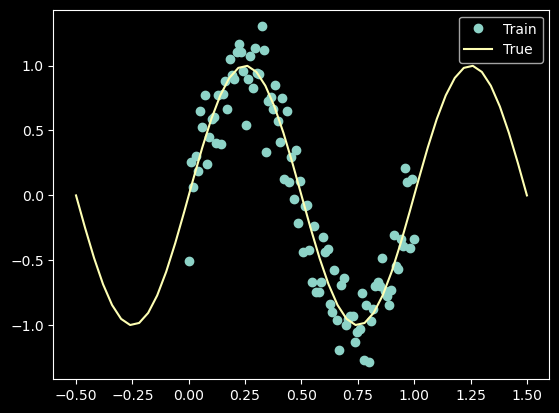

In [4]:
plt.plot(train_x, train_y, "o", label="Train")
plt.plot(test_x, test_f, label="True")
plt.legend()

Initialize the model

In [4]:
# create a model with default parameters
model = GPR(
    kernel=SquaredExponential(),
)

In [6]:
model.print()

name                trainable    forward    backward          prior             type       dtype    shape      value
------------------  -----------  ---------  ----------------  ----------------  ---------  -------  -------  -------
kernel lengthscale  True         softplus   inverse_softplus  Normal(0.0, 1.0)  ArrayImpl  float64  ()             1
sigma               True         softplus   inverse_softplus  Normal(0.0, 1.0)  ArrayImpl  float64  ()             1


In [18]:
# we can also create a model by providing custom parameters
lengthscale = Parameter(1.0, trainable=True, forward_transform=softplus, backward_transform=inverse_softplus, prior=NormalPrior(loc=1.0, scale=2.0))
sigma = Parameter(0.2, trainable=False, forward_transform=softplus, backward_transform=inverse_softplus, prior=NormalPrior())


model2 = GPR(
    kernel=SquaredExponential(),
    kernel_params=dict(lengthscale=lengthscale),
    sigma=sigma,
)

model2.print()

name                trainable    forward    backward          prior             type       dtype    shape      value
------------------  -----------  ---------  ----------------  ----------------  ---------  -------  -------  -------
kernel lengthscale  True         softplus   inverse_softplus  Normal(1.0, 2.0)  ArrayImpl  float64  ()           1
sigma               False        softplus   inverse_softplus  Normal(0.0, 1.0)  ArrayImpl  float64  ()           0.2


Fit using SciPy's L-BFGS-B

In [8]:
model.fit(train_x, train_y)

In [9]:
model.print()

name                trainable    forward    backward          prior             type       dtype    shape       value
------------------  -----------  ---------  ----------------  ----------------  ---------  -------  -------  --------
kernel lengthscale  True         softplus   inverse_softplus  Normal(0.0, 1.0)  ArrayImpl  float64  ()       0.411059
sigma               True         softplus   inverse_softplus  Normal(0.0, 1.0)  ArrayImpl  float64  ()       0.217113


In [10]:
# Predict (with full covariance)
yhat, covhat = model.predict(test_x, full_covariance=True)
err = 2 * jnp.diag(covhat) ** 0.5

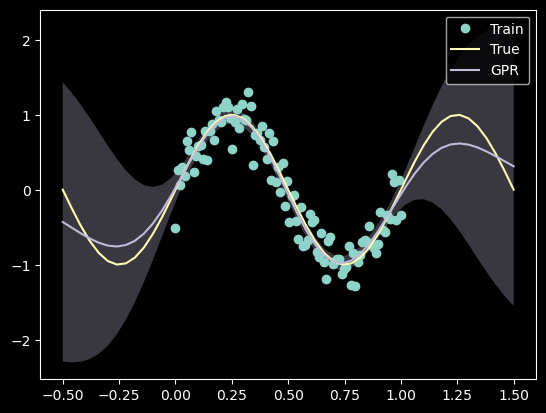

In [11]:
# Plot prediction
plt.plot(train_x, train_y, "o", label="Train", c="C0")
plt.plot(test_x, test_f, label="True", c="C1")
plt.plot(test_x, yhat, label="GPR", c="C2")
plt.fill_between(
    test_x.reshape(-1),
    yhat.reshape(-1) - err,
    yhat.reshape(-1) + err,
    alpha=0.3,
    facecolor="C2",
)
plt.legend()

In [12]:
# Log marginal likelihood
model.log_marginal_likelihood(train_x, train_y, return_negative=True)

Array(2.23833523, dtype=float64)

Fit using SciPy's L-BFGS-B with multiple restarts

In [19]:
model2.fit(
    train_x, 
    train_y,
    num_restarts=2,
    key=random.PRNGKey(2023),
    return_history=True
)

In [20]:
# Predict (with full covariance)
yhat, covhat = model2.predict(test_x, full_covariance=True)
err = 2 * jnp.diag(covhat) ** 0.5

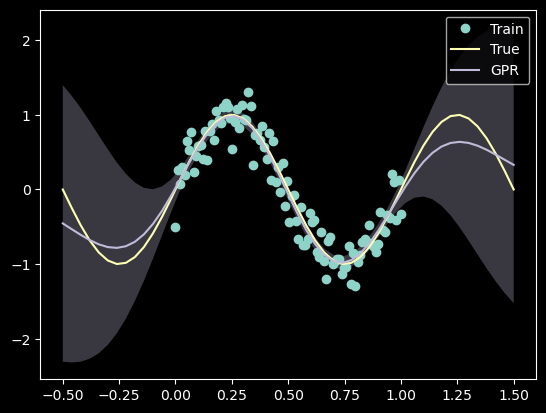

In [21]:
# Plot prediction
plt.plot(train_x, train_y, "o", label="Train", c="C0")
plt.plot(test_x, test_f, label="True", c="C1")
plt.plot(test_x, yhat, label="GPR", c="C2")
plt.fill_between(
    test_x.reshape(-1),
    yhat.reshape(-1) - err,
    yhat.reshape(-1) + err,
    alpha=0.3,
    facecolor="C2",
)
plt.legend()

In [22]:
# Log marginal likelihood
model2.log_marginal_likelihood(train_x, train_y, return_negative=True)

Array(2.91041074, dtype=float64)

In [23]:
# Log marginal likelihood at each restart
model2.losses_history_

[Array(2.91041074, dtype=float64),
 Array(2.91041074, dtype=float64),
 Array(2.91041074, dtype=float64)]

Comparison with GPFlow (if available)

In [27]:
try:

    import gpflow
    from gpflow.utilities import print_summary
    from gpflow.models import GPR as gpf_GPR
    from gpflow.kernels import RBF
    from gpflow.mean_functions import Constant as C
    import numpy as np

    gpf_model = gpf_GPR(
        (np.array(train_x), np.array(train_y)), kernel=RBF(), mean_function=C()
    )
    gpflow.set_trainable(gpf_model.mean_function.c, False)
    gpflow.set_trainable(gpf_model.kernel.variance, False)

    opt = gpflow.optimizers.Scipy()
    opt.minimize(gpf_model.training_loss, gpf_model.trainable_variables)

    # Note that the RBF kernel of gpflow has lengthscale *= 1/np.sqrt(2)
    # Note that is also reports the likelihood variance (sigma ** 2)
    print_summary(gpf_model)
    print(gpf_model.log_marginal_likelihood())


except ModuleNotFoundError:
    pass

2023-04-14 11:25:26.036779: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-04-14 11:25:26.911916: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-04-14 11:25:26.912032: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-04-14 11:25:26.912038: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed proper